In [1]:
import numpy as np
import pickle
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], dict[b'labels']

def load_cifar10_data(data_dir):
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(data_dir, 'data_batch_%d' % b)
        X, Y = load_cifar10_batch(f)
        xs.append(X)
        ys.append(Y)
    X_train = np.concatenate(xs)
    y_train = np.concatenate(ys)
    X_test, y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    return X_train, y_train, X_test, y_test

data_dir = 'data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_cifar10_data(data_dir)

# 特征提取：将图像数据展平
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(f'训练集形状: {X_train.shape}, 测试集形状: {X_test.shape}')

训练集形状: (50000, 3072), 测试集形状: (10000, 3072)


In [3]:
# 归一化
X_train_normal = X_train.astype('float32') / 255.0
X_test_normal = X_test.astype('float32') / 255.0

In [ ]:
from sklearn.decomposition import PCA

# PCA降维
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_normal)
X_test_pca = pca.transform(X_test_normal)

print(f'降维后的训练集形状: {X_train_pca.shape}, 降维后的测试集形状: {X_test_pca.shape}')

In [5]:
k_values = range(1, 101)
precisions = []
recalls = []
f1_scores = []

for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)
    
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

print("Finish")

100%|██████████| 100/100 [05:16<00:00,  3.16s/it]

Finish


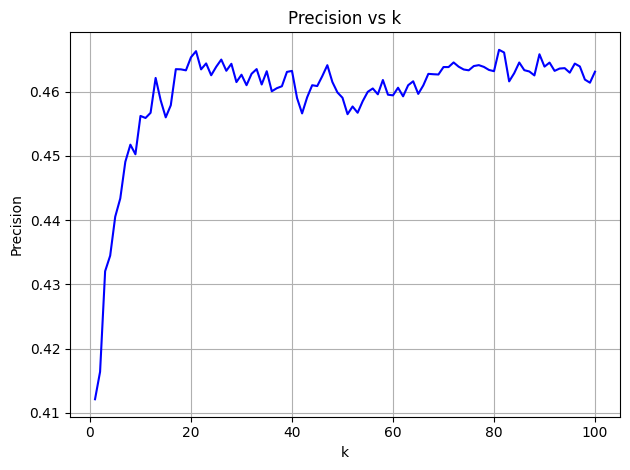

In [6]:
plt.figure()
plt.plot(k_values, precisions, label='Precision', color='blue')
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('Precision vs k')
plt.grid(True)
plt.tight_layout()
plt.show()

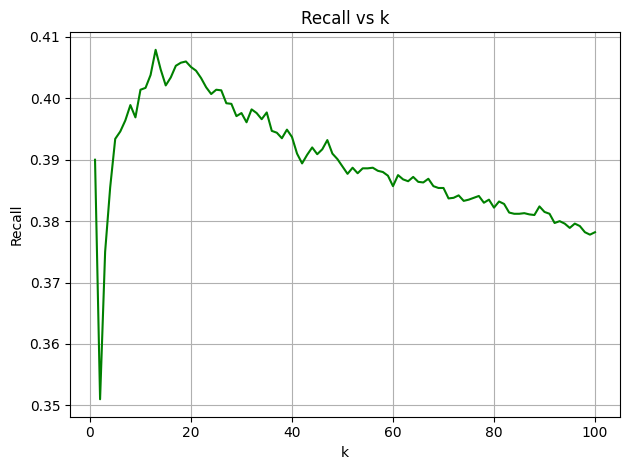

In [7]:
plt.figure()
plt.plot(k_values, recalls, label='Recall', color='green')
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('Recall vs k')
plt.grid(True)
plt.tight_layout()
plt.show()

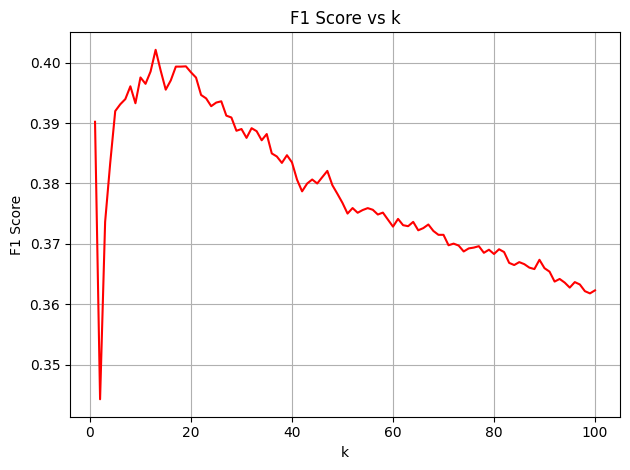

In [8]:
plt.figure()
plt.plot(k_values, f1_scores, label='F1 Score', color='red')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score vs k')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# 找出最佳k值
best_k = k_values[np.argmax(f1_scores)]
print(f"\n最佳k值: {best_k}")
print(f"最佳F1分数: {max(f1_scores):.4f}")
print(f"对应的查准率: {precisions[best_k-1]:.4f}")
print(f"对应的召回率: {recalls[best_k-1]:.4f}")


最佳k值: 13
最佳F1分数: 0.4021
对应的查准率: 0.4621
对应的召回率: 0.4079


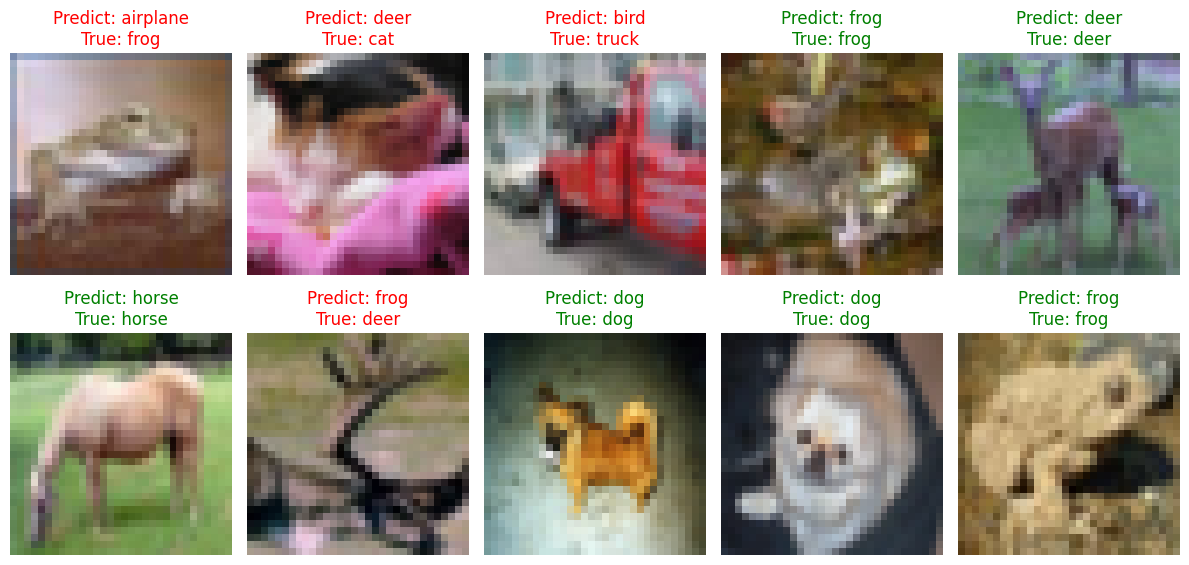

In [10]:
# CIFAR-10数据集的真实标签
label_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# 可视化一些预测结果
def plot_predictions(X_test, y_test, y_pred, indices):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, idx in enumerate(indices):
        ax = axes[i//5, i%5]
        img = X_test[idx]
        img = img.reshape((-1, 1024))
        r = img[0, :].reshape((32, 32)) 
        g = img[1, :].reshape((32, 32)) 
        b = img[2, :].reshape((32, 32)) 
        image = np.zeros((32, 32, 3))
        image[:, :, 0] = r / 255
        image[:, :, 1] = g / 255
        image[:, :, 2] = b / 255
        ax.imshow(image)
        ax.axis('off')
        pred_label = label_names[y_pred[idx]]
        true_label = label_names[y_test[idx]]
        ax.set_title(f'Predict: {pred_label}\nTrue: {true_label}', 
                    color='green' if y_pred[idx]==y_test[idx] else 'red')
    plt.tight_layout()
    plt.show()

# 使用最佳k值的模型进行预测
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_pca, y_train)
y_pred = best_knn.predict(X_test_pca)

# 随机选择10个样本展示预测结果
random_indices = np.random.choice(len(X_test), 10, replace=False)
plot_predictions(X_test, y_test, y_pred, random_indices)